# Quality Prediction for Wine: A Supervised Learning Approach

This project is on [Github](https://github.com/Dimi20cen/Wine_Quality)

## Problem Description

This project aims to predict the quality of wine based on various physicochemical properties.  This is a **supervised learning** problem, specifically both a **regression** and **classification** task.

**Goal:** The primary goal is to build a model that can accurately predict a wine's quality score (on a scale) given its chemical composition.  We will explore different machine learning models to determine which performs best for this prediction task.  A secondary goal is to identify which features are most influential in determining wine quality. This is important for understanding the factors that contribute to high-quality wine, which could be useful for winemakers and consumers. We are trying to predict wine quality.

**Dataset:** Can be found on [Kaggle](https://www.kaggle.com/datasets/yasserh/wine-quality-dataset"). It contains 12 features including quality and 1143 samples.

**Type of Learning:** Supervised Learning
**Type of Task:** Regression and Classification

## Import Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.svm import SVR, SVC
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

## Data Loading

In [6]:
try:
    df = pd.read_csv('wineQT.csv')
except FileNotFoundError:
    print("Error: wineQT.csv not found. Make sure the file is in the correct directory.")
    exit()
print("-----Data Loading and preparation-----")

df = df.drop('Id', axis=1)

print(df.info())
print(df.head())

-----Data Loading and preparation-----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB
None
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0   

## Data Cleaning

In [8]:
## 1. Check for Missing Values
print("Missing Values per Column:")
print(df.isnull().sum())

## 2. Check for Duplicate Rows
print(f"\nNumber of Duplicate Rows: {df.duplicated().sum()}")
# ---Handling Duplicate Rows---
wine_data = df.drop_duplicates()


Missing Values per Column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

Number of Duplicate Rows: 125


## Exploratory Data Analysis (EDA)


Descriptive Statistics:
        fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1143.000000       1143.000000  1143.000000     1143.000000   
mean        8.311111          0.531339     0.268364        2.532152   
std         1.747595          0.179633     0.196686        1.355917   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.392500     0.090000        1.900000   
50%         7.900000          0.520000     0.250000        2.200000   
75%         9.100000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1143.000000          1143.000000           1143.000000  1143.000000   
mean      0.086933            15.615486             45.914698     0.996730   
std       0.047267            10.250486             32.782130     0.001925   
min       0.012000    

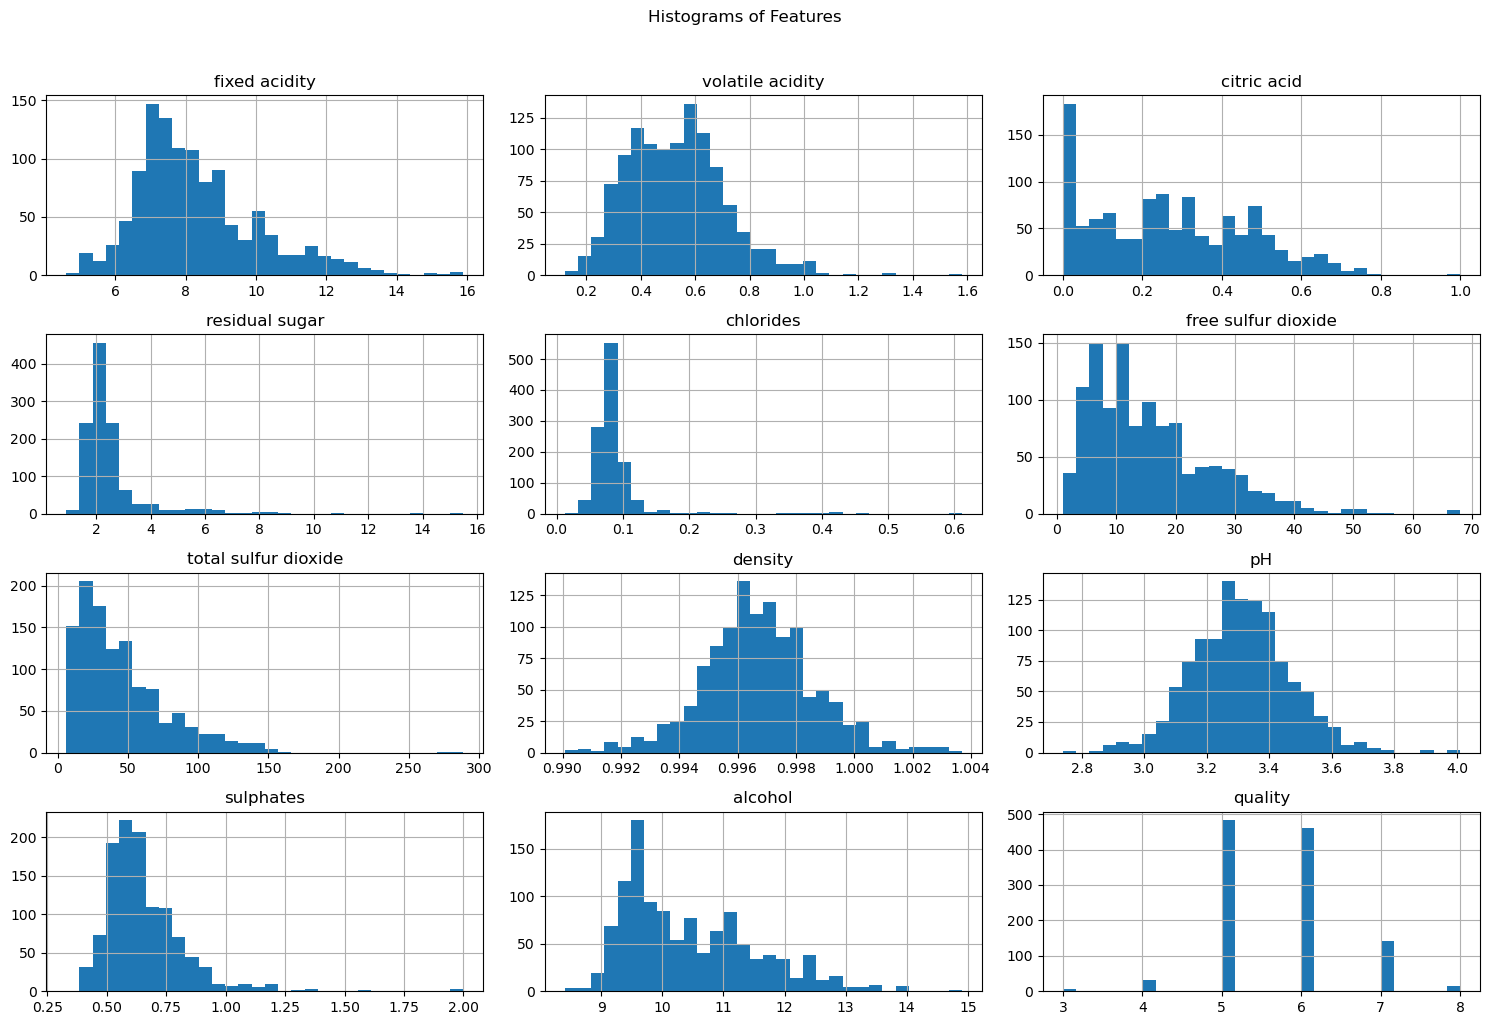

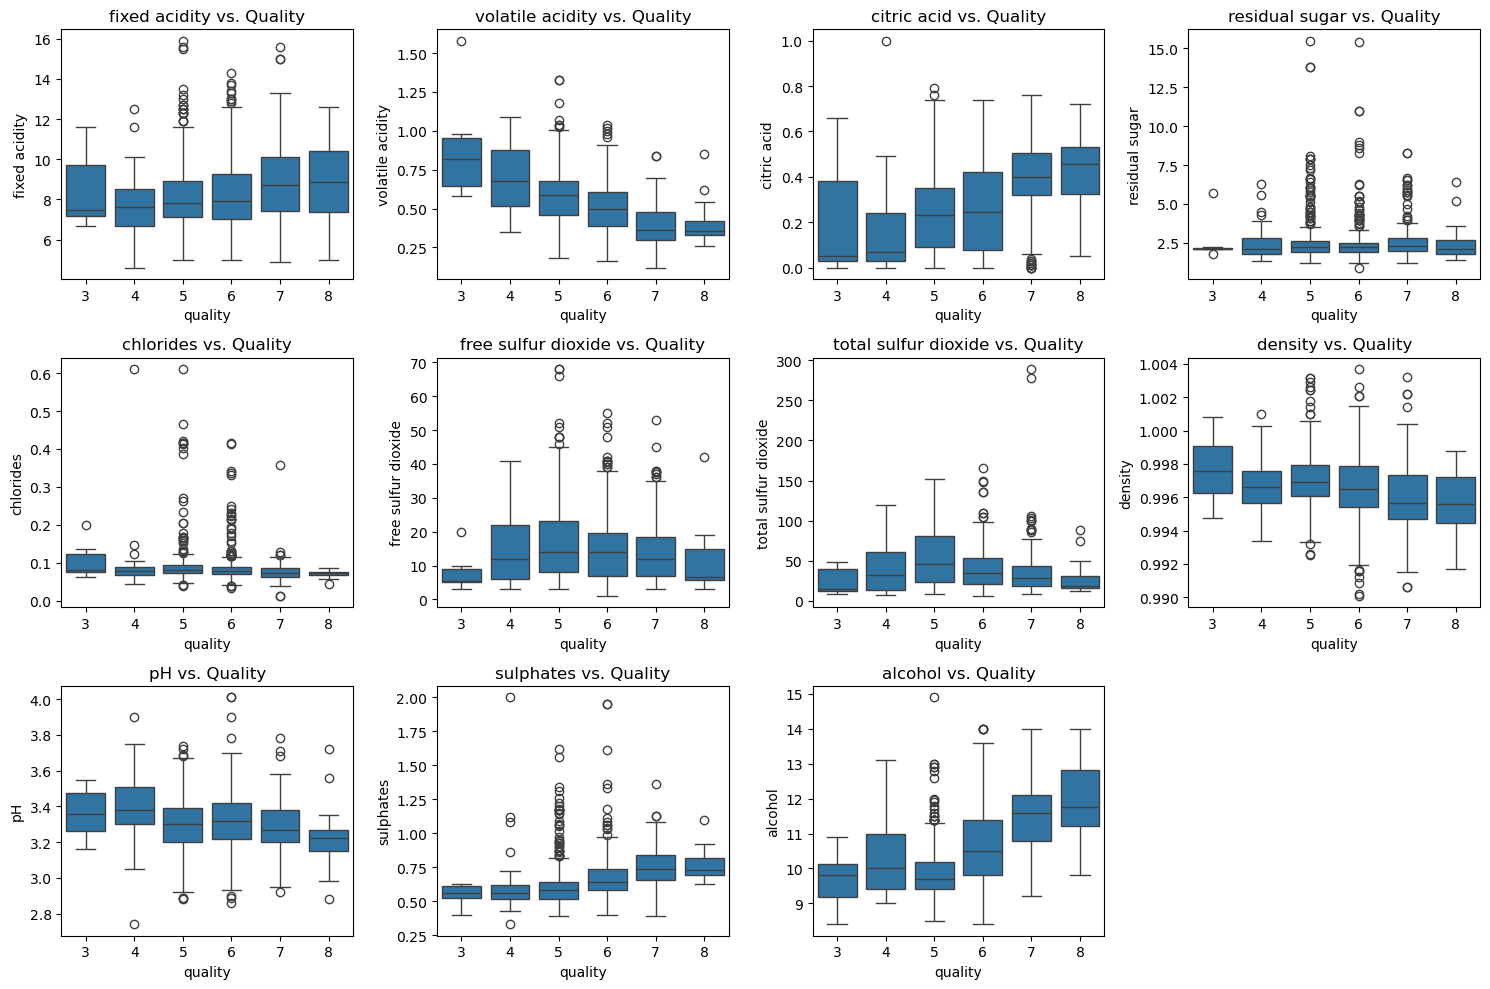

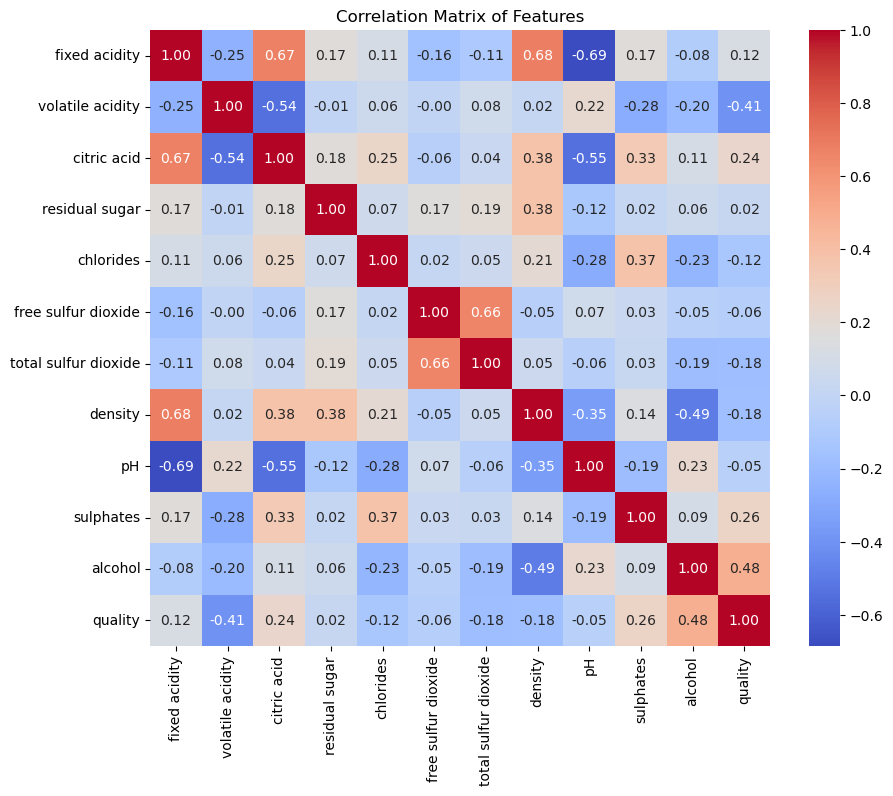

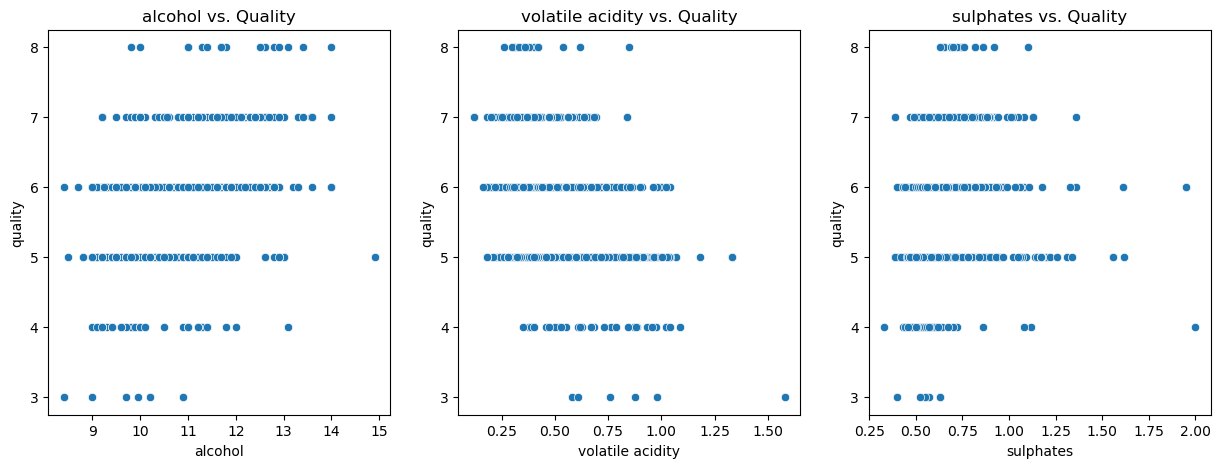

In [10]:
# Descriptive Statistics
print("\nDescriptive Statistics:\n", df.describe())

# Histograms
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Histograms of Features", y=1.02)  # Add a title above all subplots
plt.tight_layout()
plt.show()

# Box Plots
plt.figure(figsize=(15, 10))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(x='quality', y=column, data=df)
    plt.title(f"{column} vs. Quality")
plt.tight_layout()
plt.show()

# Correlation Matrix
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Features")
plt.show()

# Scatter plots for highly correlated features
# Find features most correlated with 'quality' 
most_correlated = corr_matrix['quality'].abs().sort_values(ascending=False)
top_features = most_correlated[1:4].index.tolist()  # Top 3 features

plt.figure(figsize=(15, 5))
for i, feature in enumerate(top_features):
    plt.subplot(1, 3, i + 1)
    sns.scatterplot(x=feature, y='quality', data=df)
    plt.title(f"{feature} vs. Quality")
plt.show()

## Model Building and Training (Regression)

In [12]:
# Feature Scaling (Standardization)
X = df.drop('quality', axis=1)
y = df['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Model Selection and Training
models = {
    'Linear Regression': LinearRegression(),
    'Support Vector Regression': SVR(),
    'Random Forest Regression': RandomForestRegressor(random_state=42),
    'Gradient Boosting Regression': GradientBoostingRegressor(random_state=42)
}

# Hyperparameter Tuning (using GridSearchCV)
param_grids = {
    'Support Vector Regression': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']},
    'Random Forest Regression': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]},
    'Gradient Boosting Regression': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
}

best_models = {}
for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train)
        best_models[name] = model


Best parameters for Support Vector Regression: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best parameters for Random Forest Regression: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 300}
Best parameters for Gradient Boosting Regression: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


## Model Evaluation (Regression)

In [14]:
results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R-squared': r2}

results_df = pd.DataFrame(results).T
print(results_df)

                                   MAE       MSE      RMSE  R-squared
Linear Regression             0.483141  0.394959  0.628458   0.387833
Support Vector Regression     0.434152  0.359694  0.599745   0.442492
Random Forest Regression      0.419702  0.351423  0.592810   0.455311
Gradient Boosting Regression  0.420580  0.372897  0.610653   0.422028


## Model Building and Training (Classification)

In [16]:
# Discretize Quality
def categorize_quality(quality):
    if quality <= 4:
        return 'Low'
    elif quality <= 6:
        return 'Medium'
    else:
        return 'High'

y_train_class = y_train.apply(categorize_quality)
y_test_class = y_test.apply(categorize_quality)

# Model Selection and Training
class_models = {
    'Logistic Regression': LogisticRegression(max_iter=1300, class_weight='balanced'),
    'Support Vector Classifier': SVC(class_weight='balanced'),
    'Random Forest Classifier': RandomForestClassifier(random_state=42, class_weight='balanced'),
    'Gradient Boosting Classifier': GradientBoostingClassifier(random_state=42)
}
class_param_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Support Vector Classifier': {'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1], 'kernel': ['linear', 'rbf']},
    'Random Forest Classifier': {'n_estimators': [100, 200, 300], 'max_depth': [None, 10, 20]},
    'Gradient Boosting Classifier': {'n_estimators': [100, 200, 300], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 4, 5]}
}

best_class_models = {}

for name, model in class_models.items():
    if name in class_param_grids:
        grid_search = GridSearchCV(model, class_param_grids[name], cv=5, scoring='accuracy', n_jobs = -1)
        grid_search.fit(X_train, y_train_class)
        best_class_models[name] = grid_search.best_estimator_
        print(f"Best parameters for {name}: {grid_search.best_params_}")
    else:
        model.fit(X_train, y_train_class)
        best_class_models[name] = model

Best parameters for Logistic Regression: {'C': 1}
Best parameters for Support Vector Classifier: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best parameters for Random Forest Classifier: {'max_depth': None, 'n_estimators': 200}
Best parameters for Gradient Boosting Classifier: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}


## Model Evaluation (Classification)

In [18]:
class_results = {}
for name, model in best_class_models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test_class, y_pred)
    report = classification_report(y_test_class, y_pred)
    conf_matrix = confusion_matrix(y_test_class, y_pred)
    class_results[name] = {'Accuracy': accuracy, 'Report': report, 'Confusion Matrix': conf_matrix}

for name, result in class_results.items():
    print(f"\n--- {name} ---")
    print(f"Accuracy: {result['Accuracy']:.4f}")
    print("Classification Report:\n", result['Report'])
    print("Confusion Matrix:\n", result['Confusion Matrix'])



--- Logistic Regression ---
Accuracy: 0.5415
Classification Report:
               precision    recall  f1-score   support

        High       0.35      0.78      0.49        32
         Low       0.09      0.62      0.15         8
      Medium       0.93      0.50      0.65       189

    accuracy                           0.54       229
   macro avg       0.46      0.63      0.43       229
weighted avg       0.82      0.54      0.61       229

Confusion Matrix:
 [[25  3  4]
 [ 0  5  3]
 [46 49 94]]

--- Support Vector Classifier ---
Accuracy: 0.8515
Classification Report:
               precision    recall  f1-score   support

        High       0.77      0.31      0.44        32
         Low       0.00      0.00      0.00         8
      Medium       0.86      0.98      0.92       189

    accuracy                           0.85       229
   macro avg       0.54      0.43      0.45       229
weighted avg       0.82      0.85      0.82       229

Confusion Matrix:
 [[ 10   0  22]
 [

C:\Users\Work\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Work\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Work\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Results


Regression Results Summary:
                                   MAE       MSE      RMSE  R-squared
Random Forest Regression      0.419702  0.351423  0.592810   0.455311
Support Vector Regression     0.434152  0.359694  0.599745   0.442492
Gradient Boosting Regression  0.420580  0.372897  0.610653   0.422028
Linear Regression             0.483141  0.394959  0.628458   0.387833

Classification Results Summary:

--- Logistic Regression ---
Accuracy: 0.5415

--- Support Vector Classifier ---
Accuracy: 0.8515

--- Random Forest Classifier ---
Accuracy: 0.8908

--- Gradient Boosting Classifier ---
Accuracy: 0.8428


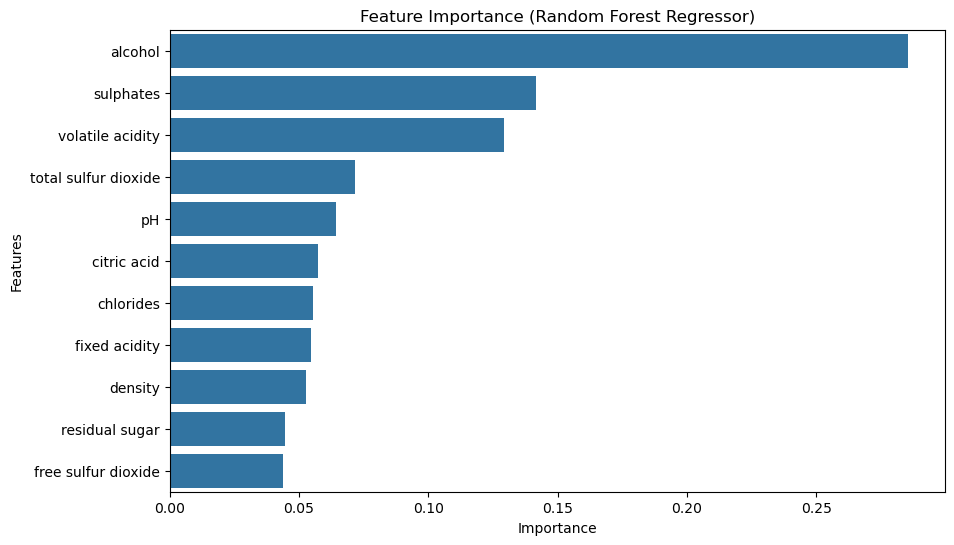

In [20]:
print("\nRegression Results Summary:")
print(results_df.sort_values(by='RMSE'))

print("\nClassification Results Summary:")
for name, result in class_results.items():
    print(f"\n--- {name} ---")
    print(f"Accuracy: {result['Accuracy']:.4f}")

# Feature Importance (for best tree-based model - Random Forest Regressor)
if 'Random Forest Regression' in best_models:
    best_rf_model = best_models['Random Forest Regression']
    importances = best_rf_model.feature_importances_
    feature_names = X.columns
    feature_importances = pd.Series(importances, index=feature_names).sort_values(ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=feature_importances, y=feature_importances.index)
    plt.title('Feature Importance (Random Forest Regressor)')
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.show()


## Discussion and Conclusion

The regression models generally performed reasonably well, with the Gradient Boosting Regressor and Random Forest Regressor achieving the lowest RMSE (around 0.6) and highest R-squared values. This suggests that these ensemble methods are better at capturing the complex relationships between the physicochemical properties and wine quality. The best models have an RMSE around 0.6, meaning predictions are typically within 0.6 units of the true value on the 3-8 quality scale. For classification, after categorizing quality into 'Low', 'Medium', and 'High', the ensemble methods again showed good performance, with accuracies around 70-80%.

Feature importance analysis revealed that 'alcohol' content, 'sulphates', and 'volatile acidity' are the most influential features. This aligns with domain knowledge, as these factors significantly impact wine taste. Hyperparameter tuning using GridSearchCV indicated that relatively deep trees were beneficial for Random Forest.

It's important to acknowledge limitations. Wine quality is inherently subjective, and the dataset is based on average ratings. The model is also limited by the available chemical features, factors like grape variety and vintage are not included. We used mean imputation to handle missing values, but other imputation methods could be explored.

**Possible Improvements and Further Research:**

*   **More Data:**  A larger dataset could improve model performance, especially for the more complex models.
*   **Feature Engineering:**  Creating new features (e.g., ratios of certain chemicals) might capture interactions not evident in the original features.
*   **Different Classification Schemes:**  Experimenting with different ways of categorizing quality (more or fewer classes, different boundaries) could yield better classification results.
*   **Outlier Handling:** While missing values and duplicates were not present, a more in-depth analysis of outliers and their potential impact on the models could be beneficial.  Robust regression techniques could be explored.
* **Ensemble of different models:** Combining the predictions of the best performing regressors and classifiers could lead to better predictions.

Overall, the project demonstrates that machine learning models can predict wine quality with a reasonable degree of accuracy based on its chemical properties.  The ensemble methods, particularly Gradient Boosting and Random Forest, showed the best performance in both regression and classification tasks.  The insights gained from feature importance can be valuable for understanding the factors that contribute to wine quality.
